MINI PROJECT 2

WORK FLOW: 
The computation entails the following steps.

    Select the dimensions of study (L in m; t in Days);
1. Select projection to use. Albers Equal Area Conic CONUS, NAD 83 (2011); EPSG:6350
2. Select the Well Location (get lat-lon coordinates) convert to AEA projection
3. Extract Transmissivity values at the well (from interpolated T gpkg file)
4. Obtain the mean water levels (computed earlier) for wells in a gpkg fle
5. Convert the meam water levels file to AEA projection and compute X and Y coordinates
6. Compute the regional groundwater flow using linear regression of Hydraulic Head (from MSL) against X and Y
7. Use the coefficients of X and Y to obtain the gradients along X and Y axis and compute resultant gradient
8. Compute the capture zone polygon in model coordinates (well is at 0,0)
9. Convert the capture zone polygon to AEA projection coordinates use suitable transformation
10. Transform the coordinates obtained in the above step such that X-axis is oriented along the groundwater flow direction
11. Create a shapely polygon (object) of the capture zone. Export to a gpkg file
12. Overlay the capture zone polygon onto the Jefferson County Map; Embellish the plot as appropriate.

By obeying the workflow, please find the solution below:

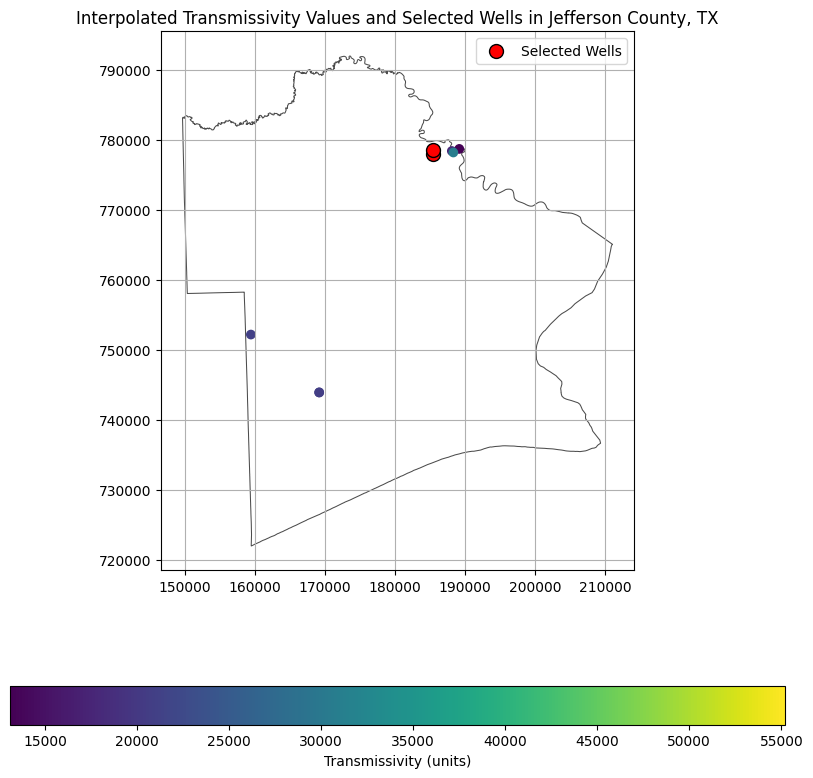

In [45]:
selected_wells = [4,5]  # Replace with actual Well IDs from Tvalues
selected_Tvalues = Tvalues[Tvalues['WellID'].isin(selected_wells)]
fig, ax = plt.subplots(figsize=(10, 10))
Jeff.plot(ax=ax, color='none', edgecolor='black', alpha=0.7, linewidth=0.75)
Tvalues.plot(column='T', ax=ax, cmap='viridis', legend=True, legend_kwds={'label': "Transmissivity (units)", 'orientation': "horizontal"})
selected_Tvalues.plot(ax=ax, color='red', edgecolor='black', marker='o', markersize=100, label='Selected Wells')
plt.title("Interpolated Transmissivity Values and Selected Wells in Jefferson County, TX")
plt.grid(visible=True)
plt.legend()
plt.show()

<h4> Read Water Level Data</h4> 
Read Water Level from files('WaterLevelsMajor.txt') subset those for the Gulf Coast Aquifer

In [46]:
a = pd.read_csv('WellMain.txt', sep = '|', encoding = 'ISO-8859-1',low_memory=False)

In [47]:
a.columns

Index(['StateWellNumber', 'County', 'RiverBasin', 'GMA', 'RWPA', 'GCD',
       'AquiferCode', 'AquiferCodeDescription', 'AquiferId', 'Aquifer',
       'Classification', 'AquiferPickMethod', 'LatitudeDD', 'Dlat', 'Mlat',
       'Slat', 'LongitudeDD', 'Dlong', 'Mlong', 'Slong', 'CoordinateSource',
       'Owner', 'Driller', 'WellDepth', 'DepthSource', 'LandSurfaceElevation',
       'LandSurfaceElevationMethod', 'DrillingStartDate', 'DrillingMonth',
       'DrillingDay', 'DrillingYear', 'DrillingEndDate', 'DrillingMethod',
       'BoreHoleCompletion', 'WellType', 'Pump', 'PowerType', 'WellUse',
       'WaterLevelStatus', 'CurrentWaterLevelWell', 'WaterQualityAvailable',
       'CurrentWaterQualityWell', 'ReportingAgency', 'OtherDataAvailable',
       'Remarks', 'WellReportTrackingNumber', 'PluggingReportTrackingNumber',
       'USGSSiteNumber', 'TCEQSourceId', 'GCDWellNumber', 'OwnerWellNumber',
       'OtherWellNumber', 'PreviousStateWellNumber', 'CreatedDate',
       'LastUpdateDate'],


In [48]:
cols= ['StateWellNumber','County','LongitudeDD','LatitudeDD','LandSurfaceElevationMethod','WellDepth']

In [49]:
asub = a.loc[a.County=='Jefferson',cols]
asub.head()

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth
104893,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0
104894,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0
104895,6154903,Jefferson,-94.271111,30.159445,Interpolated From Topo Map,550.0
104896,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0
104897,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0


In [50]:
asub.describe()

,StateWellNumber,LongitudeDD,LatitudeDD,WellDepth
count,4.280000e+02,428.000000,428.000000,422.000000
mean,6.283796e+06,-94.185266,29.971791,449.199052
std,1.163050e+05,0.137146,0.119684,1426.164637
min,6.154901e+06,-94.442500,29.657223,6.000000
25%,6.163052e+06,-94.280208,29.883055,52.750000
50%,6.301204e+06,-94.194306,29.993195,152.500000
75%,6.407829e+06,-94.094583,30.060556,280.000000
max,6.424601e+06,-93.872500,30.180278,15005.000000


In [51]:
fname = 'WaterLevelsMajor.txt'
b = pd.read_csv(fname, sep = '|', encoding = 'ISO-8859-1',low_memory=False)

In [52]:
b.columns #List all the columns

Index(['StateWellNumber', 'County', 'Aquifer', 'Status', 'MeasurementMonth',
       'MeasurementDay', 'MeasurementYear', 'MeasurementDate',
       'MeasurementTime', 'DepthFromLSD', 'LandElevation',
       'LandElevationMethod', 'WaterElevation', 'MeasurementNumber',
       'MeasuringAgency', 'MethodOfMeasurement', 'Remarks', 'Comments',
       'CreatedDate', 'LastUpdateDate'],
      dtype='object')

In [53]:
bcol = ['StateWellNumber','MeasurementYear','WaterElevation','DepthFromLSD']

In [54]:
bsub = b.loc[b.County=='Jefferson',bcol] #Subset all rows of selected
bsub.head()

,StateWellNumber,MeasurementYear,WaterElevation,DepthFromLSD
878119,6154901,1941.0,23.10,6.90
878120,6154902,1986.0,-7.00,35.00
878121,6154902,1987.0,-3.25,31.25
878122,6154902,1989.0,-9.90,37.90
878123,6154902,1989.0,-16.36,44.36


In [55]:
WLGCNumeric = bsub[['StateWellNumber','WaterElevation','DepthFromLSD']]
WLM = WLGCNumeric.groupby('StateWellNumber').mean()#Take Temprary Mean
WLM.dropna(inplace=True)
print(WLM)

                 WaterElevation  DepthFromLSD
StateWellNumber                              
6154901               23.100000      6.900000
6154902              -17.178889     45.178889
6154904              -17.287143     44.287143
6154905              -25.338571     51.338571
6155504               32.000000    -18.000000
...                         ...           ...
6423201                1.800000      3.200000
6423302                1.900000      1.100000
6423303                1.900000      1.100000
6424501                2.500000      2.500000
6424502                2.000000      3.000000

[195 rows x 2 columns]


<h4>Merge Aeverage Water Level and Well info into one table

In [56]:
# By getting the wells that are same data set
WellData = pd.merge(asub,WLM,on= 'StateWellNumber', how = 'inner')
WellData = WellData.loc[WellData.DepthFromLSD > 0]
WellData.to_csv('Mean.csv') #make a Copy for future use
WellData.head()

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD
0,6154901,Jefferson,-94.266112,30.134722,Interpolated From Topo Map,21.0,23.100000,6.900000
1,6154902,Jefferson,-94.271111,30.159167,Digital Elevation Model -DEM,450.0,-17.178889,45.178889
2,6154904,Jefferson,-94.270278,30.161667,Digital Elevation Model -DEM,530.0,-17.287143,44.287143
3,6154905,Jefferson,-94.271389,30.159167,Interpolated From Topo Map,572.0,-25.338571,51.338571
7,6155701,Jefferson,-94.213889,30.130555,Interpolated From Topo Map,68.0,27.000000,9.000000


In [57]:
#Set CRS - NAD 83 AND EPSG 6350

geometry = [Point(xy) for xy in zip(WellData['LongitudeDD'], WellData['LatitudeDD'])]
Wellgpf = gpd.GeoDataFrame(WellData, geometry=geometry)
Wellgpf.set_crs(epsg=6350, inplace=True)
print(Wellgpf)

     StateWellNumber     County  LongitudeDD  LatitudeDD  \
0            6154901  Jefferson   -94.266112   30.134722   
1            6154902  Jefferson   -94.271111   30.159167   
2            6154904  Jefferson   -94.270278   30.161667   
3            6154905  Jefferson   -94.271389   30.159167   
7            6155701  Jefferson   -94.213889   30.130555   
..               ...        ...          ...         ...   
190          6423201  Jefferson   -94.199722   29.742500   
191          6423302  Jefferson   -94.164167   29.741389   
192          6423303  Jefferson   -94.161667   29.739445   
193          6424501  Jefferson   -94.072500   29.668055   
194          6424502  Jefferson   -94.072778   29.667778   

       LandSurfaceElevationMethod  WellDepth  WaterElevation  DepthFromLSD  \
0      Interpolated From Topo Map       21.0       23.100000      6.900000   
1    Digital Elevation Model -DEM      450.0      -17.178889     45.178889   
2    Digital Elevation Model -DEM      530.0 

In [58]:
selected = [6164505, 6164506]
selected_wells = WellData[WellData.StateWellNumber.isin(selected)]
selected_wells

,StateWellNumber,County,LongitudeDD,LatitudeDD,LandSurfaceElevationMethod,WellDepth,WaterElevation,DepthFromLSD
66,6164505,Jefferson,-94.073889,30.053056,Interpolated From Topo Map,775.0,-21.193333,47.193333
67,6164506,Jefferson,-94.073889,30.066944,Interpolated From Topo Map,765.0,-14.666667,39.666667


In [61]:
# CALCULATE HYDRAULIC HEAD FOR EACH PAIR ABOVE
hydraulic_head = [water + depth for water, depth in zip(water_elevation, depth_from_lsd)]
hydraulic_head

[26.000000000000004, 24.999999999999996]

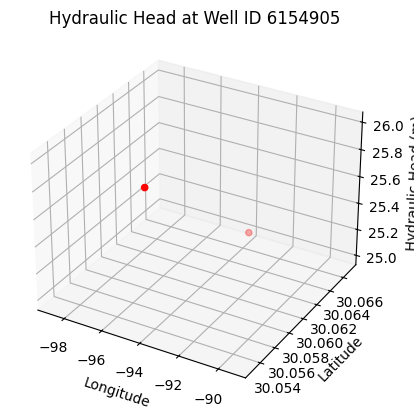

In [3]:
import matplotlib.pyplot as plt # USING CHATGPT
from mpl_toolkits.mplot3d import Axes3D # USING CHATGPT
latitude = [30.053056, 30.066944]
longitude = [-94.03889,-94.03889] 
hydraulic_head = [26.000000000000004, 24.999999999999996]

# FOR CREATING FIGURE
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(longitude, latitude, hydraulic_head, c='r', marker='o') # USING CHAT GPT

# FOR LABLES
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Hydraulic Head (m)')
plt.title('Hydraulic Head at Well ID 6154905')
plt.show()


In [5]:
# FILTERING WELL DATA GEODATAFRAME FOR SELECTED WELLS

selected = [6164505, 6164506]
selected_wells = WellData[WellData.StateWellNumber.isin(selected)]

# ChecKING IF GEOMETRY COLUMN EXIST

if 'geometry' not in selected_wells.columns:
# CREATE GEOMETRY FROM LAT AND LON IF NOT AVAILABLE # USING CHATGPT

selected_wells['geometry'] = selected_wells.apply(lambda row: Point(row['LongitudeDD'], row['LatitudeDD']), axis=1)
print("Selected Wells in EPSG:6350:")
print(selected_wells[['StateWellNumber', 'LongitudeDD', 'LatitudeDD', 'geometry']])
real_world_coordinates = selected_wells[['LongitudeDD', 'LatitudeDD']].values
model_origin = np.array([0, 0])
model_coordinates = []
for coord in real_world_coordinates:
real_world_coord = np.array(coord)
# TRANSFORM TO MODEL COORDINATES

model_coord = model_origin - real_world_coord
model_coordinates.append(model_coord)
model_geometries = [Point(coord) for coord in model_coordinates]
model_gdf = gpd.GeoDataFrame({'StateWellNumber': selected,'geometry': model_geometries}, crs='EPSG:6350')
print("Transformed Model Coordinates GeoDataFrame:")
print(model_gdf)
fig, ax = plt.subplots(figsize=(8, 8))
model_gdf.plot(ax=ax, color='red', marker='o', markersize=100, label='Model Wells')
x_coords = model_gdf.geometry.x
y_coords = model_gdf.geometry.y
padding = 1.0  # Adjust the padding as needed
ax.set_xlim(x_coords.min() - padding, x_coords.max() + padding)
ax.set_ylim(y_coords.min() - padding, y_coords.max() + padding)
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.title("Model Coordinates of Selected Wells")
plt.xlabel("Model X Coordinate")
plt.ylabel("Model Y Coordinate")
plt.legend()
plt.grid()
plt.show()

NameError: name 'WellData' is not defined

In [1]:
# Sample data for the well and neighboring wells
data = {
    'StateWellNumber': [6164505, 6164506],
    'LongitudeDD': [-94.03889, -94.03889],
    'LatitudeDD': [30.053056, 30.066944],
    'WaterElevation': [-21.193333, -14.666667]  # Ensure that the length matches the number of wells
}

df = pd.DataFrame(data)

# Calculate differences to find gradients
df['dx'] = df['LongitudeDD'] - df['LongitudeDD'].mean()
df['dy'] = df['LatitudeDD'] - df['LatitudeDD'].mean()
df['dh'] = df['WaterElevation'] - df['WaterElevation'].mean()

# Calculate gradients (dh/dx and dh/dy)
df['a'] = df['dh'] / df['dx'].replace(0, np.nan)  # Handle division by zero
df['b'] = df['dh'] / df['dy'].replace(0, np.nan)  # Handle division by zero

# Average gradients
a = df['a'].mean()
b = df['b'].mean()

print(f"Gradient a (dh/dx): {a}")
print(f"Gradient b (dh/dy): {b}")

# Fit the regression model
X = df[['dx', 'dy']]
X = sm.add_constant(X)  # Add intercept
y = df['WaterElevation']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


Gradient a (dh/dx): nan
Gradient b (dh/dy): 469.95002880191424
                            OLS Regression Results                            
Dep. Variable:         WaterElevation   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 05 Nov 2024   Prob (F-statistic):                nan
Time:                        19:17:39   Log-Likelihood:                 63.704
No. Observations:                   2   AIC:                            -123.4
Df Residuals:                       0   BIC:                            -126.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\Users\demon\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
C:\Users\demon\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
C:\Users\demon\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\demon\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(se

In [68]:
import geopandas as gpd

# Load T values from the CSV file
fname = 'Tvalues.csv'
Tv = gpd.read_file(fname)

# Define constants
Pop = 22500  # Population
pcu = 135    # Gallons per day per capita
conversion_factor = 0.133681  # Gallons to cubic feet conversion factor
Q = Pop * pcu * conversion_factor  # Total water consumption in cubic feet
B = 100     # Assumed aquifer thickness (in feet)

# Output the total water consumption
print(f"Total water consumption (Q) in cubic feet: {Q:.2f}")

# Design parameters
tyears = 10  # Design time in years
S = 0.005    # Storage coefficient

# Extract T values from GeoDataFrame
T = Tv['T']  # Ensure 'T' is the correct column name in your GeoDataFrame
print(f"T values: {T.tolist()}")


Total water consumption (Q) in cubic feet: 406056.04
T values: ['55200', '13100', '18000', '18300', '16300', '30800', '21000', '21300', '20800']


In [69]:
import numpy as np

# Values for Q, T, and i
Q = 406056.04  # Discharge in m^3/s (example value)
T = np.array([55200, 13100, 18000, 18300, 16300, 30800, 21000, 21300, 20800])  # Transmissivity in m^2/s
i = 0.2  # Hydraulic gradient (example value)

# Select a specific transmissivity value (for example, the first value in T)
T_index = 0  # Change this index to select a different T value
T_selected = T[T_index]  # Get the selected T value

def stagnation_point(Q, T, i):
    """Calculate the stagnation point x_s."""
    return -Q / (2 * np.pi * T * i)

def max_y(Q, T, i):
    """Calculate the maximum y values as a tuple (positive, negative)."""
    y_max = Q / (T * i)  # Calculate maximum y for the transmissivity value
    return y_max, -y_max

def capture_zone_boundary(y, Q, T, i):
    """Calculate the x value along the capture zone boundary for a given y."""
    return -y / np.tan((2 * np.pi * T * i * y) / Q)

# Stagnation point for the selected T value
x_s = stagnation_point(Q, T_selected, i)

# Maximum y values for the selected T
y_max_positive, y_max_negative = max_y(Q, T_selected, i)

# Outputs (You can print or use them as needed)
print(f"Stagnation Point (x_s) for T[{T_index}]: {x_s}")
print(f"Maximum y values (positive) for T[{T_index}]: {y_max_positive}")
print(f"Maximum y values (negative) for T[{T_index}]: {y_max_negative}")
print(f"Capture Zone Boundary for y={y_example} and T[{T_index}]: {x_boundary}")


Stagnation Point (x_s) for T[0]: -5.8537885813695985
Maximum y values (positive) for T[0]: 36.7804384057971
Maximum y values (negative) for T[0]: -36.7804384057971
Capture Zone Boundary for y=10 and T[0]: [  1.38372177 -23.29993399 -16.05519106 -15.72789971 -18.11316457
  -7.10317605 -13.15722469 -12.90671405 -13.32765717]


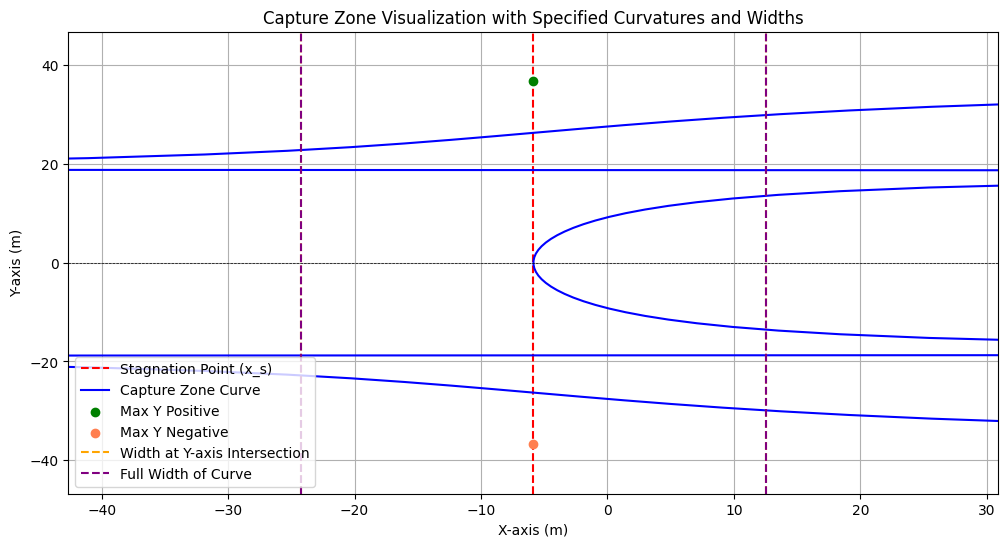

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Values for Q, T, and i
Q = 406056.04  # Discharge in m^3/s (example value)
T = np.array([55200, 13100, 18000, 18300, 16300, 30800, 21000, 21300, 20800])  # Transmissivity in m^2/s
i = 0.2  # Hydraulic gradient (example value)

# Select a specific transmissivity value
T_index = 0  # Change this index to select a different T value
T_selected = T[T_index]  # Get the selected T value

# Specified maximum and minimum y values
y_max_positive = 36.7804384057971
y_max_negative = -36.7804384057971

# Calculate the stagnation point
def stagnation_point(Q, T, i):
    """Calculate the stagnation point x_s."""
    return -Q / (2 * np.pi * T * i)

# Calculate widths
width_half = Q / (2 * T_selected * i)  # Width at Y-axis intersection
full_width = Q / (T_selected * i)  # Full width of the curve

# Calculate stagnation point for the selected T value
x_s = stagnation_point(Q, T_selected, i)

# Generate y values for the curve
y_values = np.linspace(y_max_negative, y_max_positive, 100)
x_values = np.zeros_like(y_values)

# Calculate the x values based on the curvature
for idx, y in enumerate(y_values):
    if y == 0:
        x_values[idx] = x_s
    else:
        x_values[idx] = -y / np.tan((2 * np.pi * T_selected * i * y) / Q)

# Plotting the capture zone
plt.figure(figsize=(12, 6))

# Plot the stagnation point
plt.axvline(x=x_s, color='red', linestyle='--', label='Stagnation Point (x_s)')

# Plot the capture zone curve
plt.plot(x_values, y_values, label='Capture Zone Curve', color='blue')

# Mark the maximum y values
plt.scatter([x_s], [y_max_positive], color='green', label='Max Y Positive', zorder=5)
plt.scatter([x_s], [y_max_negative], color='coral', label='Max Y Negative', zorder=5)

# Indicate the width at Y-axis intersection and full width
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
plt.axvline(x=x_s + width_half, color='orange', linestyle='--', label='Width at Y-axis Intersection')
plt.axvline(x=x_s - width_half, color='orange', linestyle='--')
plt.axvline(x=x_s + full_width / 2, color='purple', linestyle='--', label='Full Width of Curve')
plt.axvline(x=x_s - full_width / 2, color='purple', linestyle='--')

# Labeling the plot
plt.title('Capture Zone Visualization with Specified Curvatures and Widths')
plt.xlabel('X-axis (m)')
plt.ylabel('Y-axis (m)')

# Move the legend to the bottom left corner
plt.legend(loc='lower left')

plt.grid()
plt.ylim(y_max_negative - 10, y_max_positive + 10)  # Set y limits for better visibility
plt.xlim(x_s - full_width, x_s + full_width)  # Adjust x limits for better visibility
plt.show()


Selected Wells in EPSG:6350:
   StateWellNumber  LongitudeDD  LatitudeDD                  geometry
0          6164501     -77.0369     38.9072  POINT (-77.0369 38.9072)


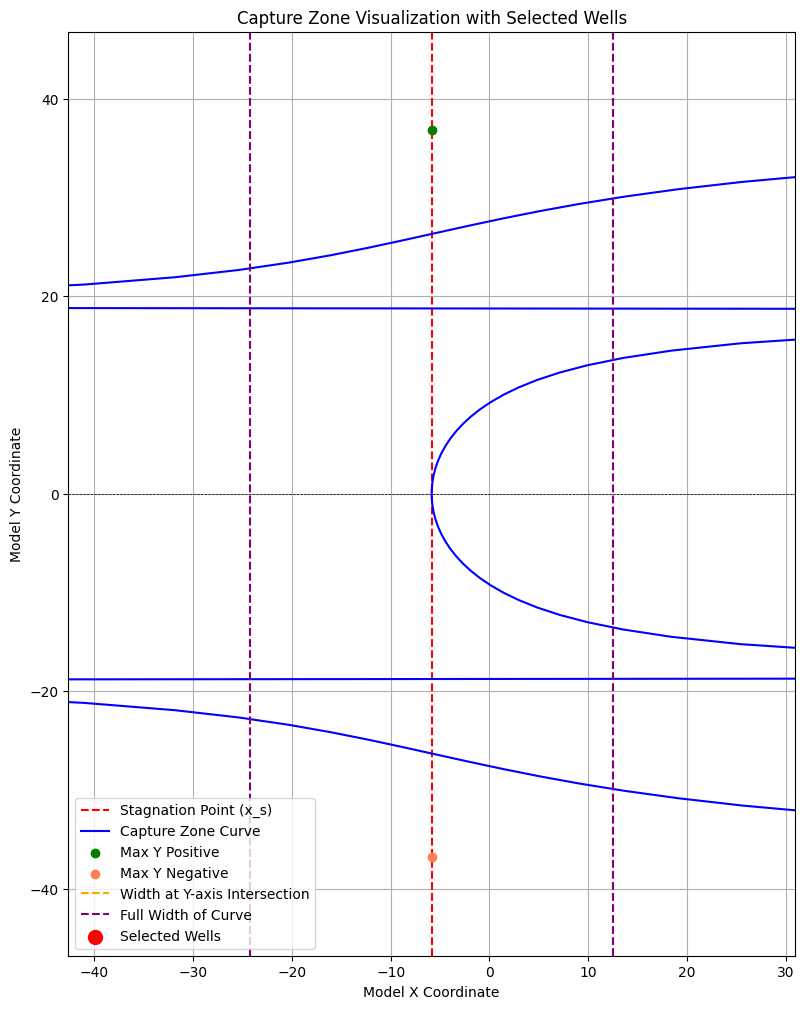

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Well Data Example (replace this with your actual GeoDataFrame)
# Assuming WellData is a GeoDataFrame with 'StateWellNumber', 'LongitudeDD', 'LatitudeDD', and possibly 'geometry' columns
WellData = gpd.GeoDataFrame({
    'StateWellNumber': [6164501],
    'LongitudeDD': [-77.0369],
    'LatitudeDD': [38.9072]
})

# Assuming you have WellData GeoDataFrame and it has been filtered for selected wells
selected = [6164501]
selected_wells = WellData[WellData.StateWellNumber.isin(selected)]

# Check if the geometry column exists
if 'geometry' not in selected_wells.columns:
    # If geometry is not available, create it from LongitudeDD and LatitudeDD
    selected_wells['geometry'] = selected_wells.apply(lambda row: Point(row['LongitudeDD'], row['LatitudeDD']), axis=1)

# Display the selected well coordinates in EPSG:6350
print("Selected Wells in EPSG:6350:")
print(selected_wells[['StateWellNumber', 'LongitudeDD', 'LatitudeDD', 'geometry']])

# Extract the real-world coordinates from the selected wells GeoDataFrame
real_world_coordinates = selected_wells[['LongitudeDD', 'LatitudeDD']].values

# Define the model origin (0, 0)
model_origin = np.array([0, 0])

# Calculate model coordinates by subtracting real-world coordinates from model origin
model_coordinates = []
for coord in real_world_coordinates:
    real_world_coord = np.array(coord)
    # Transform to model coordinates
    model_coord = model_origin - real_world_coord
    model_coordinates.append(model_coord)

# Define the geometry for the transformed model coordinates
model_geometries = [Point(coord) for coord in model_coordinates]

# Create a new GeoDataFrame for the model coordinates
model_gdf = gpd.GeoDataFrame({
    'StateWellNumber': selected,
    'geometry': model_geometries
}, crs='EPSG:6350')  # Set the CRS to EPSG:6350

# Plotting the capture zone with selected wells
# Values for Q, T, and i
Q = 406056.04  # Discharge in m^3/s (example value)
T = np.array([55200, 13100, 18000, 18300, 16300, 30800, 21000, 21300, 20800])  # Transmissivity in m^2/s
i = 0.2  # Hydraulic gradient (example value)

# Select a specific transmissivity value
T_index = 0  # Change this index to select a different T value
T_selected = T[T_index]  # Get the selected T value

# Specified maximum and minimum y values
y_max_positive = 36.7804384057971
y_max_negative = -36.7804384057971

# Calculate the stagnation point
def stagnation_point(Q, T, i):
    """Calculate the stagnation point x_s."""
    return -Q / (2 * np.pi * T * i)

# Calculate widths
width_half = Q / (2 * T_selected * i)  # Width at Y-axis intersection
full_width = Q / (T_selected * i)  # Full width of the curve

# Calculate stagnation point for the selected T value
x_s = stagnation_point(Q, T_selected, i)

# Generate y values for the curve
y_values = np.linspace(y_max_negative, y_max_positive, 100)
x_values = np.zeros_like(y_values)

# Calculate the x values based on the curvature
for idx, y in enumerate(y_values):
    if y == 0:
        x_values[idx] = x_s
    else:
        x_values[idx] = -y / np.tan((2 * np.pi * T_selected * i * y) / Q)

# Plotting the capture zone
plt.figure(figsize=(12, 12))

# Plot the stagnation point
plt.axvline(x=x_s, color='red', linestyle='--', label='Stagnation Point (x_s)')

# Plot the capture zone curve
plt.plot(x_values, y_values, label='Capture Zone Curve', color='blue')

# Mark the maximum y values
plt.scatter([x_s], [y_max_positive], color='green', label='Max Y Positive', zorder=5)
plt.scatter([x_s], [y_max_negative], color='coral', label='Max Y Negative', zorder=5)

# Indicate the width at Y-axis intersection and full width
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
plt.axvline(x=x_s + width_half, color='orange', linestyle='--', label='Width at Y-axis Intersection')
plt.axvline(x=x_s - width_half, color='orange', linestyle='--')
plt.axvline(x=x_s + full_width / 2, color='purple', linestyle='--', label='Full Width of Curve')
plt.axvline(x=x_s - full_width / 2, color='purple', linestyle='--')

# Plot the model coordinates
model_gdf.plot(ax=plt.gca(), color='red', marker='o', markersize=100, label='Selected Wells')

# Labeling the plot
plt.title('Capture Zone Visualization with Selected Wells')
plt.xlabel('Model X Coordinate')
plt.ylabel('Model Y Coordinate')

# Move the legend to the bottom left corner
plt.legend(loc='lower left')

plt.grid()
plt.ylim(y_max_negative - 10, y_max_positive + 10)  # Set y limits for better visibility
plt.xlim(x_s - full_width, x_s + full_width)  # Adjust x limits for better visibility
plt.show()
